In [0]:
import pandas as pd
import numpy as np

import spacy
import torchtext
from torchtext import data
from torchtext import vocab

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 1. YELP DATASET PREPROCESSING

If you use the dataset placed under the * ./datasets/exp2/* directory, you are ready to skip to step 2 since the dataset is already pre-processed.

In [0]:
# yelp_df = pd.read_csv('./yelp_df_100k.csv', error_bad_lines=False) # error_bad_lines=False, drop bad_lines
# yelp_df.shape

In [0]:
# yelp_df.head()

In [0]:
# import re
# def clean_text(text):
#     text = text.lower()
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "can not ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r"\'scuse", " excuse ", text)
#     text = re.sub('\W', ' ', text)
#     text = re.sub('\s+', ' ', text)
#     text = re.sub('[0-9]+', '', text)
#     text = re.sub(' +', ' ', text) # replace double spaces with single
#     text = text.replace("_","")
#     text = text.strip(' ')
#     return text

In [0]:
# # check if yelp_df hold the data
# yelp_df.shape

In [0]:
# yelp_df.head()

In [0]:
# # check if there are null values
# yelp_df.loc[pd.isnull(yelp_df).any(1),:]
# yelp_df = yelp_df[yelp_df["text"] != ""]

In [0]:
# # if there are nulls, remove rows that have null values for text or stars cells
# yelp_df = yelp_df.dropna()

In [0]:
# # clean the dataframe
# yelp_df['text'] = yelp_df['text'].map(lambda com : clean_text(com))

In [0]:
# # scale stars to range 0-4
# yelp_df['stars'] = yelp_df['stars'].apply(lambda x: x-1)
# yelp_df.stars.unique()

In [0]:
# # removal of stop words
# nltk.download('stopwords')
# stop = stopwords.words('english')
# yelp_df['text'] = yelp_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [0]:
# # lemmatization
# nltk.download('wordnet')
# lemmatizer = WordNetLemmatizer()
# yelp_df['text'] = yelp_df['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

In [0]:
# yelp_df.to_csv('./yelp_df_100k.csv', encoding='utf-8')

## 2. Process dataset using torchtext

** Load the dataset of 100k samples **

In [0]:
# # Load 100k Yelp reviews having 20k reviews for each of 5 classes
main_df = pd.read_csv('./yelp_df_100k.csv', error_bad_lines=False) # error_bad_lines=False, drop bad_lines

In [0]:
# # Check for empty text or stars
np.where(main_df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [0]:
print(main_df.head())
main_df['text'] = main_df['text'].str.findall('\w{3,}').str.join(' ')
print(main_df.head())

   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                                                text  stars  
0  pizza okay best prefer biaggio flamingo fort a...      1  
1  love place fiance go atleast week portion huge...      4  
2  terrible dry corn bread rib tip fat mushy flav...      0  
3  back place favorite thai place ever would go a...      1  
4  delicious healthy food steak amazing fish pork...      4  
   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                                                text  stars  
0  pizza okay best prefer biaggio flamingo fort a...      1  
1  love place fiance atleast week portion huge fo...      4  
2  terrible dry corn bread rib tip fat mushy flav...      0  
3  bac

In [0]:
# # Remove two first un-important columns (Unnamed: 0	Unnamed: 0.1)
main_df.drop(main_df.columns[[0, 1]], axis=1, inplace=True)

In [0]:
# # Split to train and test
train_df, test_df = train_test_split(main_df, test_size=0.2)

In [0]:
# # Get the validation set as well
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [0]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(64000, 2)
(16000, 2)
(20000, 2)


In [0]:
df_train.head()

,text,labels
0,wife went last night shrimp dish carne asada s...,0
1,used called real bagel done fabulous job revam...,0
2,location continues disappoint service always s...,0
3,place simply worth price one tuna steak carte ...,0
4,chili cheese fry disappointed cashier know men...,0


In [0]:
df_stats_train = df_train.stars.value_counts()
df_stats_test = df_val.stars.value_counts()
df_stats_val = df_test.stars.value_counts()

plt.figure(figsize=(12,5))
plt.title('Number of reviews per score')
ax1 = df_stats_train.sort_index(ascending=True).plot(color='blue', grid=True, label='Train data', kind='bar', legend=False)
ax2 = df_stats_test.sort_index(ascending=True).plot(color='red', grid=True, label='Test data', kind='bar', legend=False)
ax3 = df_stats_val.sort_index(ascending=True).plot(color='orange', grid=True, label='Val data', kind='bar', legend=False)
ax1.legend(loc=1)
ax2.legend(loc=2)
ax3.legend(loc=3)
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.show()

In [0]:
# Store in separate CSV files so torchtext can read them
df_train.to_csv('./yelp_train.csv', encoding='utf-8', index=False)
df_val.to_csv('./yelp_val.csv', encoding='utf-8', index=False)
df_test.to_csv('./yelp_test.csv', encoding='utf-8', index=False)

**Tokenization**

In [0]:
# tokanize reviews
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
def tokenizer(s):
    return [w.text.lower() for w in nlp(s)]

**Define fields**

In [0]:
# columns to be processed
text_field = data.Field(sequential=True, 
                       tokenize=tokenizer,
                       include_lengths=True, 
                       use_vocab=True)

star_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)

df_fields = [
    ('text', text_field),
    ('stars', star_field)
]

In [0]:
# Load datasets and create torchtext dataset
trainds, valds, testds = data.TabularDataset.splits(path='./', 
                                            format='csv', 
                                            train='yelp_train.csv',
                                            validation='yelp_val.csv',
                                            test='yelp_test.csv', 
                                            fields=df_fields, 
                                            skip_header=True)

In [0]:
len(trainds), len(valds), len(testds)

(64000, 16000, 20000)

In [0]:
ex = trainds[1]
print(type(ex), '\n')
print(trainds.fields.items(), '\n')
print(ex.stars, '\n')
print(ex.text)

<class 'torchtext.data.example.Example'> 

dict_items([('text', <torchtext.data.field.Field object at 0x7f1364442ef0>), ('stars', <torchtext.data.field.Field object at 0x7f1364442d68>)]) 

0 

['place', 'high', 'rise', 'within', 'complex', 'shop', 'store', 'often', 'slow', 'call', 'cell', 'ask', 'come', 'shop', 'n', 'ni', 'went', 'weekend', 'check', 'decent', 'experience', 'one', 'acknowledged', 'helped', 'get', 'fitting', 'room', 'quickly', 'n', 'nwhile', 'waiting', 'line', 'check', 'addressed', 'person', 'behind', 'line', 'offered', 'place', 'purchase', 'behind', 'counter', 'asked', 'loyalty', 'member', 'opened', 'register', 'basically', 'talking', 'shoulder', 'completely', 'ignoring', 'spoke', 'stated', 'next', 'line', 'also', 'loyalty', 'member', 'said', 'nothing', 'continued', 'ignore', 'handed', 'item', 'left', 'store', 'n', 'na', 'minute', 'later', 'called', 'manager', 'stated', 'bad', 'experience', 'asked', 'store', 'stop', 'calling', 'needed', 'business', 'started', 'rattling'

## 3. Load pretrained word vectors and building vocabulary

In [0]:
# load glove embeddings
emb = vocab.Vectors('glove.6B.100d.txt', './')

100%|█████████▉| 398602/400000 [00:17<00:00, 22405.80it/s]

In [0]:
# build the vocabulary using all datasets (train, val, test) and assign the vectors
text_field.build_vocab(trainds, valds, testds, max_size=500000, vectors=emb)

In [0]:
text_field.vocab.vectors.shape

torch.Size([78551, 100])

In [0]:
text_field.vocab.vectors[text_field.vocab.stoi['best']]

tensor([ 0.1389,  0.1970,  0.6961, -0.2524,  0.2782, -0.1028,  0.2617, -0.5792,
        -0.9372,  0.0171,  0.2926, -0.6789, -0.0973, -0.2325, -0.3774,  0.1612,
         0.7874, -0.1303, -0.1270,  1.1908,  0.4064,  0.1129,  0.2895, -0.1043,
         0.5443, -0.1394, -0.0482, -0.6537,  0.1601, -0.3687, -0.5638,  0.7095,
         0.1609,  0.2768,  0.6022,  0.3836, -0.7004,  0.6079, -0.4465, -0.2227,
         0.1386,  0.4198, -0.0859, -0.1451,  0.1795,  0.1058, -0.2055, -0.9602,
        -0.1128, -0.9459, -0.3793, -0.2383,  0.0799,  1.2409, -0.1147, -2.7002,
         0.0833,  0.6994,  1.0220,  0.0415, -0.4518,  1.0464, -0.4452,  0.4341,
         1.0255, -0.5429,  0.5358,  0.5550,  0.1099, -0.1937,  0.2677,  0.3745,
        -0.1229,  0.2897,  0.2591,  0.1383, -0.6663, -0.2669, -0.0437, -0.4559,
         0.2161,  0.4007, -0.3651, -0.1738, -1.5461, -0.1422, -0.1239, -0.1028,
        -0.1560, -0.3851, -0.2516,  0.1611,  0.2244, -0.2549, -0.7697,  0.4543,
        -0.3992, -0.4139,  0.7230,  0.88

## 4. Loading the data in batches

BatchGenerator is an iterable wrapper around Batch Object that returns the desired data. 
BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. This is one of the small hiccups in torchtext, therefore BatchGenerator wrapper helps here.

In [0]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [0]:
# Create the iterator 
traindl, valdl, testdl = data.BucketIterator.splits(
                                                datasets=(trainds, valds, testds), 
                                                batch_sizes=(128,128,128), 
                                                sort_key=lambda x: len(x.text), 
                                                device=device, 
                                                sort_within_batch=True, 
                                                repeat=False,
                                                shuffle = True
                                            )

# Return text and stars and make batches iterable using the BatchGenerator wrapper
train_batches = BatchGenerator(traindl, 'text', 'stars')
val_batches = BatchGenerator(valdl, 'text', 'stars')
test_batches = BatchGenerator(testdl, 'text', 'stars')

In [0]:
len(train_batches), len(val_batches), len(test_batches)

(500, 125, 157)

## 5. Model and training

**LSTM model**

In [0]:
class RNN(nn.Module):
    def __init__(   
                    self, 
                    vocab_size, 
                    embedding_dim,
                    pretrained_embeddings,
                    num_output=10, 
                    hidden_size=32, 
                    num_layers=1
                ):

        super(RNN, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.pretrained_embeddings = pretrained_embeddings
        self.num_output = num_output
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer. Replace the initial weights of the embedding layer with the pre-trained embeddings
        self.encoder = nn.Embedding(self.vocab_size, self.embedding_dim, _weight=self.pretrained_embeddings)
        self.encoder.weight.requires_grad = False # HINT: the pretrained part shouldn’t be updated during training, to avoid forgetting what they already know
        
        # Dropout
        # self.dropout = nn.Dropout(p = 0.5)
        
        # LSTM
        self.lstm = nn.LSTM(
                                input_size = self.embedding_dim, 
                                hidden_size = self.hidden_size, 
                                num_layers = self.num_layers
                            )
        
        # Output
        self.out = nn.Linear(self.hidden_size, self.num_output)
    
    def attention_unit(self, lstm_output, final_state):

        """ 
        Let's add Attention mechanism in the LSTM model. 
        Use attention to compute soft alignment score corresponding 
        between each of the hidden_state and the last hidden_state of the LSTM. 
        Use torch.bmm for the batch matrix multiplication.

        Arguments
        ---------

        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM

        ---------

        Returns : It performs attention mechanism by first computing weights for each of the sequence present 
        in lstm_output and then finally computing the new hidden state.

        Tensor Size :
            hidden.size() = (batch_size, hidden_size)
            attn_weights.size() = (batch_size, num_seq)
            soft_attn_weights.size() = (batch_size, num_seq)
            new_hidden_state.size() = (batch_size, hidden_size)

        """
        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        
        return new_hidden_state
    
    def forward(self, x, seq_lengths):

        # x.shape => (batch_size, sequence_length)
        batch_size = x.size(1)

        # Make hidden
        hidden = self.init_hidden(batch_size)

        # Make embs ... x_embed.shape => (x, batch_size, embedding_dim)
        x_embed = self.encoder(x)
        
        # Drop some nodes
        # x_embed = self.dropout(x_embed)

        # Handling padding
        x_embed_packed = pack_padded_sequence(x_embed, seq_lengths) 
        output, (hidden_final, cell_final) = self.lstm(x_embed_packed, hidden) # hidden_final.size() = (1, batch_size, hidden_size) 
            
        # LSTM WITHOUT ATTENTION
        # No need to unpack, since we are going to use the hidden only
        # Use the last hidden layer output as fc's input
        # fc_output = self.out(hidden_final[-1])

        # LSTM WITH ATTENTION
        # We need to unpack
        output, _ = pad_packed_sequence(output, batch_first=True) # ouput.size() = (batch_size, num_seq, hidden_size)
        attn_output = self.attention_unit(output, hidden_final) 
        fc_output = self.out(attn_output)
            
        return fc_output

    def init_hidden(self, batch_size):
        
        h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
        
        return (h_0, c_0)

**Traing function**

In [0]:
# train cycle
def train(model, train_batches, criterion, optimizer):
    num_batch = len(train_batches)
    total_loss = 0
    y_true_train = list()
    y_pred_train = list()
    
    for (input, seq_lengths), target in train_batches:    
        pred = model(input, seq_lengths)
        
        loss = criterion(pred, target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred_idx = torch.max(pred, dim=1)[1]

        y_true_train += list(target.cpu().data.numpy())
        y_pred_train += list(pred_idx.cpu().data.numpy())
        
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_loss = total_loss/num_batch

    return train_loss, train_acc

In [0]:
# validation cycle
def validation(model, val_batches, criterion):
    num_batch = len(val_batches)
    total_loss = 0    
    y_true_val = list()
    y_pred_val = list()
    loss_history = []
    
    with torch.no_grad():
        for (input, seq_lengths), target in val_batches:

            pred = model(input, seq_lengths)

            loss = criterion(pred, target)
                        
            total_loss += loss.item()
            loss_history.append(loss.item())

            pred_idx = torch.max(pred, dim=1)[1]
            y_true_val += list(target.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = total_loss/num_batch
    
    return val_loss, val_acc

In [0]:
# test cycle
def test(model, val_batches, criterion):
    num_batch = len(val_batches)
    total_loss = 0    
    y_true_val = list()
    y_pred_val = list()
    loss_history = []
    
    with torch.no_grad():
        for (input, seq_lengths), target in val_batches:

            pred = model(input, seq_lengths)

            loss = criterion(pred, target)
                        
            total_loss += loss.item()
            loss_history.append(loss.item())

            pred_idx = torch.max(pred, dim=1)[1]
            y_true_val += list(target.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = total_loss/num_batch
        
        cm = confusion_matrix(y_true_val, y_pred_val)
        scores = [1, 2, 3, 4, 5]
        sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=scores, yticklabels=scores)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
        
        print('Classification report: \n', classification_report(y_true_val, y_pred_val))

    return val_loss, val_acc

**Hyperparameters**

In [0]:
pretrained_embeddings = trainds.fields['text'].vocab.vectors
vocab_size = len(text_field.vocab)
embedding_dim = emb.dim
hidden_size = 256
num_output = 5
num_layers = 1

**Init model, optimizer and loss function**

In [0]:
model = RNN(
                    vocab_size = vocab_size, 
                    embedding_dim = embedding_dim, 
                    pretrained_embeddings = pretrained_embeddings,
                    num_output = num_output, 
                    hidden_size = hidden_size, 
                    num_layers = num_layers
                ).cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

**Train the model**

Training for, 300  epochs...
Embeddings dim:  100
Batch size:  128
Hidden size:  256
Layers:  1 

| Epoch: 01 | Train Loss: 1.607 | Train Acc: 23.04% | Valid Loss: 1.602 | Valid Acc: 30.53%
| Epoch: 02 | Train Loss: 1.599 | Train Acc: 30.99% | Valid Loss: 1.593 | Valid Acc: 32.27%
| Epoch: 03 | Train Loss: 1.588 | Train Acc: 32.92% | Valid Loss: 1.581 | Valid Acc: 33.09%
| Epoch: 04 | Train Loss: 1.573 | Train Acc: 33.36% | Valid Loss: 1.560 | Valid Acc: 35.36%
| Epoch: 05 | Train Loss: 1.546 | Train Acc: 34.69% | Valid Loss: 1.523 | Valid Acc: 35.16%
| Epoch: 06 | Train Loss: 1.497 | Train Acc: 35.33% | Valid Loss: 1.459 | Valid Acc: 36.81%
| Epoch: 07 | Train Loss: 1.417 | Train Acc: 38.53% | Valid Loss: 1.366 | Valid Acc: 41.20%
| Epoch: 08 | Train Loss: 1.344 | Train Acc: 42.24% | Valid Loss: 1.319 | Valid Acc: 42.55%
| Epoch: 09 | Train Loss: 1.308 | Train Acc: 43.16% | Valid Loss: 1.290 | Valid Acc: 43.71%
| Epoch: 10 | Train Loss: 1.281 | Train Acc: 44.34% | Valid Loss: 1.260 | 

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


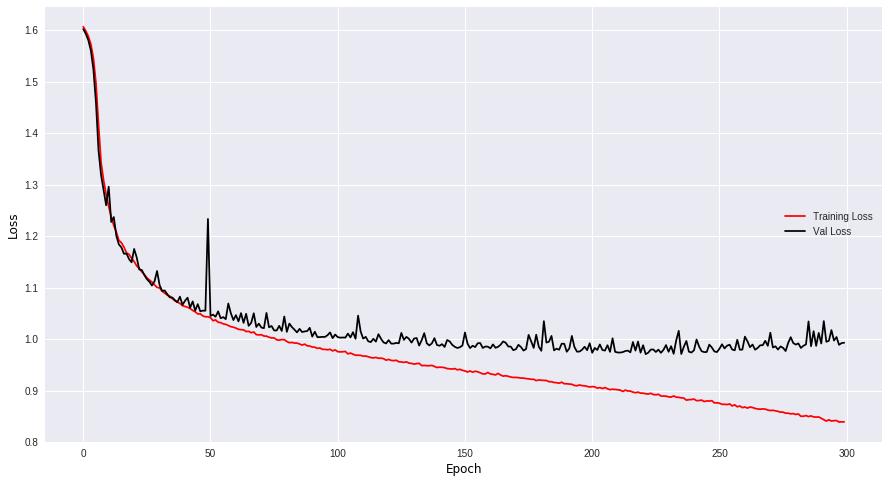

In [0]:
epochs = 300
train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

print("Training for," , epochs , " epochs...")
print("Embeddings dim: ", embedding_dim)
print("Batch size: ", train_batches.dl.batch_size)
print("Hidden size: ", hidden_size)
print("Layers: ", num_layers, "\n")

for epoch in range(1, epochs + 1):
    
    # Training
    train_loss, train_acc = train(model, train_batches, criterion, optimizer)
    
    # Validation
    val_loss, val_acc = validation(model, val_batches, criterion)
    
    # Append losses per epoch for plotting
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    # Append accuracies per epoch for plotting
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
    print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}%')

    
# Plot the losses and accuracies
fig = plt.figure(figsize=(15,8))
font = {'family' : 'Arial', 'color'  : 'black', 'weight' : 'normal', 'size'   : 12,}

ax1 = fig.add_subplot(111)
ln1 = ax1.plot(train_loss_history, 'r', label='Training Loss')
ln2 = ax1.plot(val_loss_history, 'k', label='Val Loss')

lns = ln1+ ln2
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, loc=7)
ax1.set_ylabel('Loss', fontdict=font)
ax1.set_title("Text Classification losses", fontdict=font)
ax1.set_xlabel('Epoch', fontdict=font)

plt.show()

**Test the model**

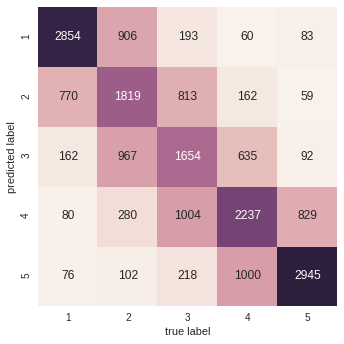

Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3942
           1       0.50      0.45      0.47      4074
           2       0.47      0.43      0.45      3882
           3       0.50      0.55      0.52      4094
           4       0.68      0.73      0.71      4008

   micro avg       0.58      0.58      0.58     20000
   macro avg       0.57      0.58      0.57     20000
weighted avg       0.57      0.58      0.57     20000

| Test Loss: 1.021 | Test Acc: 57.55% |


In [0]:
# with attention
test_loss, test_acc = test(model, test_batches, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')

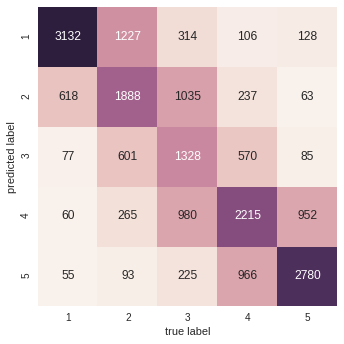

Classification report: 
               precision    recall  f1-score   support

           0       0.64      0.79      0.71      3942
           1       0.49      0.46      0.48      4074
           2       0.50      0.34      0.41      3882
           3       0.50      0.54      0.52      4094
           4       0.67      0.69      0.68      4008

   micro avg       0.57      0.57      0.57     20000
   macro avg       0.56      0.57      0.56     20000
weighted avg       0.56      0.57      0.56     20000

| Test Loss: 1.028 | Test Acc: 56.72% |


In [0]:
# w/o attention
test_loss, test_acc = test(model, test_batches, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% |')